<a href="https://colab.research.google.com/github/matthew8sweeney/computer-counterpoint-2/blob/master/music_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# for music analysis
import music21 as m21

# for fetching data from the internet
from bs4 import BeautifulSoup
from urllib.request import urlopen, urlretrieve
import time

# for displaying music notation
import os
from IPython.display import Image, Audio, clear_output

# for processing data
import numpy as np
from collections import Counter

# for model
import torch
import torch.nn.functional as F
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# for training
import matplotlib.pyplot as plt
from copy import deepcopy

## Utility


In [2]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device

device(type='cuda', index=0)

### Music21 `.show()` Setup
Allows music21 methods for showing music notation to work properly in Colab environment.  
From a [notebook](https://colab.research.google.com/gist/mscuthbert/431dee45c01598a0c11bc27823bd1c5b/music21_setup.ipynb) by Michael Cuthbert, who also created music21.

In [3]:
!apt-get install musescore > /dev/null
!apt-get install xvfb > /dev/null
!sh -e /etc/init.d/x11-common start
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = m21.environment.UserSettings()
us["musescoreDirectPNGPath"] = "/usr/bin/mscore"
us["directoryScratch"] = "/tmp/"

 * Setting up X socket directories...
   ...done.
/usr/bin/Xvfb already running.


### Functions for Playing Audio and Showing Notation.  
From a [notebook](https://colab.research.google.com/drive/17Fql7pyK3xsO8KmZorvb1tBoPomidCPB) by Robby Nevels.

In [4]:
!apt-get install lilypond > /dev/null
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [5]:
def show_lily(m21_music):
    """Liable to break if given music containing rests"""
    display(Image(str(m21_music.write('lily.png'))))

def play(m21_music):
    filename = m21_music.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

In [6]:
# this one was by me
def show_example(m21_music):
    play(m21_music)
    m21_music.show()

### Generate one-hot vectors from indices
Found on Rishabh Agrahari's [Pytorch forum](https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/26) post.

In [7]:
def ixs_to_oh(labels, num_classes):
    """
    Converts indices to one-hot vector form.

    Args:
        labels (LongTensor): class labels, sized [N,].
        num_classes (int): number of classes.

    Returns:
        tensor: encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [8]:
ixs_to_oh(torch.tensor([5, 3, 2, 4, 0, 1, 4, 3]), 6)

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.]])

## Fetch Data

### Script for fetching MIDI from Mutopia Project
From Isaiah Hull's Data Camp [article](https://www.datacamp.com/community/tutorials/using-tensorflow-to-compose-music).

In [9]:
def fetch_data_mutopia():
    # Define URL components
    url0 = 'https://www.mutopiaproject.org/cgibin/make-table.cgi?startat='
    url1 = '&searchingfor=&Composer=&Instrument=&Style=Classical&collection=&id=&solo=&recent=&timelength=&timeunit=&lilyversion=&preview='

    scores = []
    songNumber = 30
    # songNumber = 0 to start at beginning of all matching songs
    linkCount = 10

    start = time.time()

    # Locate and download each MIDI file
    m21.environment.set('autoDownload', 'allow')
    while linkCount > 0 and len(scores) < 30:  # crashes with > ~30 too much RAM
        url = url0 + str(songNumber) + url1
        html = urlopen(url)
        soup = BeautifulSoup(html.read())
        links = soup.find_all('a')
        linkCount = 0
        for link in links:
            href = link['href']
            if href.find('.mid') >= 0:
                print(href)
                linkCount += 1
                # download data and keep in `scores` list
                scores.append(m21.converter.parse(href))
        songNumber += 10
        time.sleep(2.0)
    print("got", len(scores), "scores from Mutopia Proj. in", time.time() - start, "seconds")
    return scores

In [10]:
# check if data is already ready
DATA_SAVE_PATH = "/content/drive/MyDrive/Computer Science/Deep Learning/"
try:
    # to force a reload of data
    # raise Exception("Forcing reload of data")

    # use pre-downloaded data
    tensor_chords = torch.load(DATA_SAVE_PATH+"tensor_chords.pt")
    tensorX_oh = torch.load(DATA_SAVE_PATH+"tensorX_oh.pt")
    lengths = torch.load(DATA_SAVE_PATH+"lengths.pt")
    chord_to_ix = torch.load(DATA_SAVE_PATH+"chord_to_ix.pt")
    ix_to_chord = {v: k for k, v in chord_to_ix.items()}
    DATA_SAVED = True

    # configure DataLoader
    # offset data/labels so model predicts next data point
    tensorX, tensorY = tensor_chords[:, :-1], tensor_chords[:, 1:]

    tensordata = torch.utils.data.TensorDataset(tensorX, tensorY)
    train_dl = torch.utils.data.DataLoader(tensordata, batch_size=128)

except Exception as e:
    print(e)
    # download from mutopia
    DATA_SAVED = False
    scores = fetch_data_mutopia()


In [11]:
# Inspect data
# if saved tensor is found, scores are not downloaded
if not DATA_SAVED:
    print("no. of scores:", len(scores))
    show_example(scores[0])

## Prepare Data for Model

In [12]:
def prepare(score, roman=True, figures=True, debug=False):
    """
    Do some programatic analysis of music in the given music21 Stream

    Args:
        score (music21.stream.Stream): a musical piece to analyze.
        roman (Optional, bool): whether to analyze by harmonic function or pitch.
            If True, each vertical chord is represented with a Roman numeral.
            If False, each vertical chaord is represented as a string of pitch names.
        figures (Optional, bool): whether to include figures in Roman numeral representations
        debug (Optional, bool): whether to print debug info
    
    Return:
        (Stream, list of string, list of string): Tuple of (new score, chords, durations)
    """
    # transpose to key of C M / c m, like normalization
    if debug:
        print("analyzing key")
    key = score.analyze("key")
    if debug:
        print("transposing")
    offset = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    new_score = score.transpose(offset)

    # merge all voices, grouping notes that sound at the same time into chords
    if debug:
        print("grouping chords")
    new_score = new_score.chordify()

    # seperate pitch & duration
    if debug:
        print("making chord/duration lists")
    score_chords = ["start"]  # prepend a start token to predict starting chords
    score_durations = ["start"]
    repr_chord = repr_roman(figures) if roman else repr_pitches

    for element in new_score:
        if isinstance(element, m21.chord.Chord):
            score_chords.append(repr_chord(element))
            score_durations.append(element.duration.quarterLength)
        elif isinstance(element, m21.note.Note):  # rare (literally never happens, and it shouldn't)
            print("found a lone pitch - element.pitch:", element.pitch)
            raise ValueError("single pitch")
            # score_chords.append(str(element.pitch))
            # score_durations.append(element.duration.quarterLength)

    return new_score, score_chords, score_durations

def repr_pitches(chord):
    return " ".join(str(pitch) for pitch in chord.pitches)

def repr_roman(figures: bool):
    k = m21.key.Key("C")
    if figures:
        def _repr_roman(chord):
            return m21.roman.romanNumeralFromChord(chord, k).figure
    else:
        def _repr_roman(chord):
            pass
            # return m21.roman.romanNumeralFromChord(chord).
    return _repr_roman


def dummy_prepare():
    """
    like `prepare()` but on dummy data that should be simpler/easier to learn
    """
    score_chords = ["start", "i", "ii", "i64", "V", "i", "iv", "i64", "V", "i"] * 10
    score_durations = [1] * len(score_chords)
    return None, score_chords, score_durations


def get_mappings(elements_by_score):
    # filter to unique chords/durations
    unique_elements = np.unique([e for score in elements_by_score for e in score])

    # create mappings between chord/duration and int
    element_to_ix = dict(zip(unique_elements, range(len(unique_elements))))
    ix_to_element = {v: k for k, v in element_to_ix.items()}

    return element_to_ix, ix_to_element


def get_one_hot(elements_by_score, element_to_ix, max_len):
    # convert lists of elements into one hot
    # pad end with lists of 0s to match length of longest score
    one_hot = [None] * len(elements_by_score)
    for i, score in enumerate(elements_by_score):
        score_elements = [[0] * len(element_to_ix)] * max_len
        for j, element in enumerate(score):
            encoding = [0] * len(element_to_ix)
            encoding[element_to_ix[element]] = 1
            score_elements[j] = encoding
        one_hot[i] = score_elements
    return one_hot


def get_indexes(elements_by_score, element_to_ix, max_len):
    ixs_by_score = [None] * len(elements_by_score)
    for i, score in enumerate(elements_by_score):
        score_elements = [0] * max_len
        for j, element in enumerate(score):
            element_ix = element_to_ix[element]
            score_elements[j] = element_ix
        ixs_by_score[i] = score_elements
    return ixs_by_score

In [13]:
if not DATA_SAVED:
    new_scores = [None] * len(scores)
    chords_by_score = [None] * len(scores)
    # durations_by_score = [None] * len(scores)

    start = time.time()

    # get lists of each sonority and its duration
    for i, score in enumerate(scores):
        new_score, chords, durs = prepare(score, debug=False)
        # _, chords, durs = dummy_prepare()
        # new_scores[i] = new_score
        chords_by_score[i] = chords
        # durations_by_score[i] = durs

    print("analysis took", time.time() - start, "seconds")

In [14]:
#Inspect
if not DATA_SAVED:
    print("no. of scores:", len(scores))
    # show_example(new_scores[0])

In [15]:
if not DATA_SAVED:
    start = time.time()

    # get mappings between sonority/duration and int
    chord_to_ix, ix_to_chord = get_mappings(chords_by_score)
    # duration_to_int, int_to_duration = get_mappings(durations_by_score)

    # sort by sequence length descending
    chords_by_score.sort(key=len, reverse=True)
    # durations_by_score.sort(key=len, reverse=True)

    # need lengths, this solution assumes only 1 mini-batch
    lengths = [len(score) - 1 for score in chords_by_score]
    max_seq_len = lengths[0] + 1

    # use int mappings to get one hot encoding
    # or don't because it's slow, takes much RAM
    one_hot_chords_by_score = get_one_hot(chords_by_score, chord_to_ix, max_seq_len)
    # one_hot_durs_by_score = get_one_hot(durations_by_score, duration_to_int, max_seq_len)

    # get chords/durations represented as indices
    ix_chords_by_score = get_indexes(chords_by_score, chord_to_ix, max_seq_len)

    # create tensors
    print("making tensors")
    tensor_chords = torch.tensor(ix_chords_by_score)
    # tensor_durs = torch.tensor(ix_durs_by_score)
    # just use chords for now
    packedX = torch.nn.utils.rnn.pack_padded_sequence(tensor_chords, lengths, batch_first=True, enforce_sorted=True)
    # divide into train/test sets?

    # configure DataLoader
    # tensorX = tensorX.permute(1, 0, 2)
    # offset data/labels so model predicts next data point
    tensorX, tensorY = tensor_chords[:, :-1], tensor_chords[:, 1:]
    tensorX_oh = torch.tensor(one_hot_chords_by_score)[:, :-1, :].float()

    tensordata = torch.utils.data.TensorDataset(tensorX, tensorY)
    train_dl = torch.utils.data.DataLoader(tensordata, batch_size=256)

    tensordata_oh = torch.utils.data.TensorDataset(tensorX_oh, tensorY)
    train_dl_oh = torch.utils.data.DataLoader(tensordata_oh, batch_size=256)

    print("formatting took", time.time() - start, "seconds")

    torch.save(tensor_chords, DATA_SAVE_PATH+"tensor_chords.pt")
    torch.save(tensorX_oh, DATA_SAVE_PATH+"tensorX_oh.pt")
    torch.save(chord_to_ix, DATA_SAVE_PATH+"chord_to_ix.pt")
    torch.save(lengths, DATA_SAVE_PATH+"lengths.pt")
    DATA_SAVED = True

In [16]:
print("X one hot:", tensorX_oh.shape)
print("X one hot:", tensorX_oh.dtype)
print("X:", tensorX.shape)
print("X:", tensorX.dtype)
print("X ixs:", tensorX[0, :10])
print("Y:", tensorY.shape)
print("Y:", tensorY.dtype)
print("Y ixs:", tensorY[0, :10])
print("lengths:", lengths)

X one hot: torch.Size([36, 5760, 1668])
X one hot: torch.float32
X: torch.Size([36, 5760])
X: torch.int64
X ixs: tensor([1388,  995,  995,  995,  995,  304,  304,  495,  625, 1638])
Y: torch.Size([36, 5760])
Y: torch.int64
Y ixs: tensor([ 995,  995,  995,  995,  304,  304,  495,  625, 1638,  304])
lengths: [5760, 4804, 4237, 3995, 3626, 2945, 2824, 2823, 2309, 2276, 2098, 2075, 2040, 1946, 1907, 1653, 1459, 1456, 1443, 1412, 1386, 1248, 1124, 1115, 942, 934, 882, 868, 850, 850, 823, 814, 807, 756, 713, 564]


In [17]:
print(chord_to_ix)
print("vocabulary size:", len(chord_to_ix))

{'#i': 0, '#i/o4b3': 1, '#i/ob62': 2, '#i/ob6b54b3': 3, '#i/obb64b3': 4, '#i/obb8b62': 5, '#i2': 6, '#i4': 7, '#i4b3': 8, '#i4bb3': 9, '#i5': 10, '#i54bb3': 11, '#i5b42': 12, '#i5b4bb3': 13, '#i5bb3': 14, '#i5bb42': 15, '#i6': 16, '#i62': 17, '#i63b2': 18, '#i6b5': 19, '#i6bb42': 20, '#i6bb5': 21, '#i6bb52': 22, '#i7bb64': 23, '#ib22': 24, '#ib3': 25, '#ib3b2': 26, '#ib42': 27, '#ib44': 28, '#ib4b32': 29, '#ib5b42': 30, '#ib5bb42': 31, '#ib5bb4b22': 32, '#ib64bb3': 33, '#ib66b42': 34, '#ib66bb5': 35, '#ib7': 36, '#ib74bb3': 37, '#ib75': 38, '#ib75bb4': 39, '#ib76': 40, '#ib76b53': 41, '#ib7b64': 42, '#ib7bb64': 43, '#ib8': 44, '#ib82': 45, '#ib84': 46, '#ib84bb3': 47, '#ib8b64bb3': 48, '#ib8bb3': 49, '#ib8bb64': 50, '#ib8bb7': 51, '#ib8bb7b3': 52, '#ibb3': 53, '#ibb42': 54, '#ibb64': 55, '#ibb64bb3': 56, '#ibb7': 57, '#ibb752': 58, '#ibb75b4': 59, '#ibb75bb4': 60, '#ibb7b3': 61, '#ibb7b4b3': 62, '#ibb7b7': 63, '#ibb7bb3': 64, '#ibb82': 65, '#ibb863': 66, '#io4': 67, '#io4bb3': 68, '#io

## Define Model

In [18]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_layers, bi=True, output_size=None):
        super(LSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.bi = bi

        self.lstm = torch.nn.LSTM(input_size, lstm_hidden_size, lstm_layers, bidirectional=bi)
        self.fc_out = torch.nn.Linear(lstm_hidden_size * (1+bi), output_size or input_size)

    def forward(self, x, lens, hc_old=None):
        """
        Args:
            x has shape (batch_size, seq_len, input_size)
            hc_old (tensor, tensor): optional, old hidden/cell state tuple from last time step
        """
        if hc_old is None:
            hc_old = self.__init_hidden_and_cell_state(x.shape[0])

        # "pack" variable-len sequences to avoid using autograd on padding values
        x_pack = pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=True)
        lstm_out_pack, hc = self.lstm(x_pack, hc_old)
        lstm_out, _lens = pad_packed_sequence(lstm_out_pack, batch_first=True)

        out = F.softmax(self.fc_out(lstm_out), dim=2)
        
        return out, hc
    
    def __init_hidden_and_cell_state(self, batch_size):
        # Uses __ 'name mangling' becaue who knows what names PyTorch already uses

        # create a 0-initialized hidden/cell state tuple for RNN to start a new sequence
        hc = (
            # shape is, like, (no. directions*no. layers, batch_size, hidden_size)
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.lstm_hidden_size)).to(device),
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.lstm_hidden_size)).to(device)
        )
        return hc
    
    @property
    def has_embedding(self):
        return False


class Embedding_LSTM(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_hidden_size, lstm_layers, bi=True):
        super(Embedding_LSTM, self).__init__()

        # use an embedding to better understand chord realationships
        self.embed = torch.nn.Embedding(vocab_size, embed_size)

        # use LSTM I already set up
        self.lstm_model = LSTM(embed_size, lstm_hidden_size, lstm_layers, bi=bi, output_size=vocab_size)
    
    def forward(self, x, lens, hc_old=None):
        """
        Args:
            x has shape (batch_size, seq_len, 1)
            hc_old (tensor, tensor): optional, old hidden/cell state from last time step
        """
        embed_out = self.embed(x)
        out, hc = self.lstm_model(embed_out, lens, hc_old)
        
        return out, hc
    
    @property
    def has_embedding(self):
        return True

class GRU(torch.nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_layers, bi=True, output_size=None):
        super(LSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.bi = bi

        self.lstm = torch.nn.LSTM(input_size, lstm_hidden_size, lstm_layers, bidirectional=bi)
        self.fc_out = torch.nn.Linear(lstm_hidden_size * (1+bi), output_size or input_size)

    def forward(self, x, lens, hc_old=None):
        """
        Args:
            x has shape (batch_size, seq_len, input_size)
            hc_old (tensor, tensor): optional, old hidden/cell state tuple from last time step
        """
        if hc_old is None:
            hc_old = self.__init_hidden_and_cell_state(x.shape[0])

        # "pack" variable-len sequences to avoid using autograd on padding values
        x_pack = pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=True)
        lstm_out_pack, hc = self.lstm(x_pack, hc_old)
        lstm_out, _lens = pad_packed_sequence(lstm_out_pack, batch_first=True)

        out = F.softmax(self.fc_out(lstm_out), dim=2)
        
        return out, hc
    
    def __init_hidden_and_cell_state(self, batch_size):
        # Uses __ 'name mangling' becaue who knows what names PyTorch already uses

        # create a 0-initialized hidden/cell state tuple for RNN to start a new sequence
        hc = (
            # shape is, like, (no. directions*no. layers, batch_size, hidden_size)
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.lstm_hidden_size)).to(device),
            torch.zeros(((1+self.bi)*self.lstm_layers, batch_size, self.lstm_hidden_size)).to(device)
        )
        return hc
    
    @property
    def has_embedding(self):
        return False

## Train Model

In [19]:
class StatReporter:
    def start(self):
        self.start_time = time.time()
        self.elapsed = 0
        self.target = 0
        self.loss = None

    def iteration(self, epoch, i, loss):
        self.loss = loss

        iteration_time = time.time() - self.start_time
        self.elapsed += iteration_time
        self.start_time = time.time()
        if self.elapsed > self.target:
            print(f"Epoch {epoch+1:2d}, iteration {i+1:3d}:  Loss = {loss:.3f}  Iteration time = {iteration_time:0.3f}")
            self.target += 10

    def end(self):
        print(f"Training complete.  Elapsed time: {self.elapsed:.2f} seconds  Final loss: {self.loss:0.3f}")

In [20]:
def train_model(model, dataloader, lengths, epochs, lr=0.001, debug=False, track_loss=True):
    """
    Train a given model on given data for a given number of epochs

    Args:
        model (torch.nn.Module): model to train
        dataloader (torch.utils.data.DataLoader): training data
        epochs (int): number of epochs to train for
        debug (Optional, bool): whether to print shape/dtype info
    """
    # make sure model is on the gpu (or appropriate device)
    model.to(device)

    # set up loss function and optimization algorithm
    criterion = torch.nn.CrossEntropyLoss()
    # criterion = torch.nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    # set up stat recording
    stats = StatReporter()
    stats.start()

    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            # send data to gpu
            inputs, labels = data[0].to(device), data[1].to(device)
            if debug:
                print("inputs shape:", inputs.shape)
                print("inputs dtype:", inputs.dtype)

            # zero out the gradients
            optimizer.zero_grad()

            # apply forward propagation
            outputs, _hc = model(inputs, lengths)
            if debug:
                print("outputs shape:", outputs.shape)
                print("outputs dtype:", outputs.dtype)

            # calculate loss
            # rearrange tensor to expected shape for loss func
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            # backprop
            loss.backward()
            # update model parameters
            optimizer.step()

            # show a cost/loss over iteration graph
            if track_loss:
                losses.append(float(loss))
            # if time.time()-start_time > 10 or epoch==0 or epoch==epochs-1:
            #     # Plot the cost function over the iterations completed so far
            #     clear_output(wait=True)
            #     plt.figure(figsize=(12, 8))
            #     plt.ylabel("Loss")
            #     plt.xlabel("Iteration")
            #     plt.plot(range(1, len(losses)+1), losses)
            #     plt.show()
            #     start_time = time.time()  # store a new time for triggering the next update

            # record stats for this iteration
            stats.iteration(epoch, i, loss)
            

    # end stat recording
    stats.end

In [21]:
# instantiate model based on no. of possible chords in language
# model = Embedding_LSTM(len(chord_to_int), 4, 8, 1).to(device)
model = Embedding_LSTM(len(chord_to_ix), 128, 256, 1, bi=True).to(device)
losses = []

In [22]:
# train for some no. of epochs
# train_model(model, train_dl_oh, lengths, 1000, lr=0.001)
train_model(model, train_dl, lengths, 1000, lr=0.1)
# backup_model = deepcopy(model)

Epoch  1, iteration   1:  Loss = 7.419  Iteration time = 1.181
Epoch 10, iteration   1:  Loss = 7.390  Iteration time = 1.013
Epoch 20, iteration   1:  Loss = 7.376  Iteration time = 1.014
Epoch 30, iteration   1:  Loss = 7.286  Iteration time = 1.018
Epoch 40, iteration   1:  Loss = 6.906  Iteration time = 1.017
Epoch 49, iteration   1:  Loss = 6.730  Iteration time = 1.025
Epoch 59, iteration   1:  Loss = 6.707  Iteration time = 1.021
Epoch 69, iteration   1:  Loss = 6.704  Iteration time = 1.035
Epoch 79, iteration   1:  Loss = 6.703  Iteration time = 1.043
Epoch 88, iteration   1:  Loss = 6.702  Iteration time = 1.027
Epoch 98, iteration   1:  Loss = 6.702  Iteration time = 1.039
Epoch 107, iteration   1:  Loss = 6.702  Iteration time = 1.047
Epoch 117, iteration   1:  Loss = 6.701  Iteration time = 1.053
Epoch 126, iteration   1:  Loss = 6.701  Iteration time = 1.057
Epoch 136, iteration   1:  Loss = 6.701  Iteration time = 1.061
Epoch 145, iteration   1:  Loss = 6.701  Iteration 

In [23]:
# Continuous training

# epochs = 0
# while True:
#     train_model(model, train_dl, lengths, 100, lr=0.3, track_loss=False)
#     torch.save(model, DATA_SAVE_PATH+"long_trained_model_4-7-2021_2.pt")
#     epochs += 100
#     print(epochs)

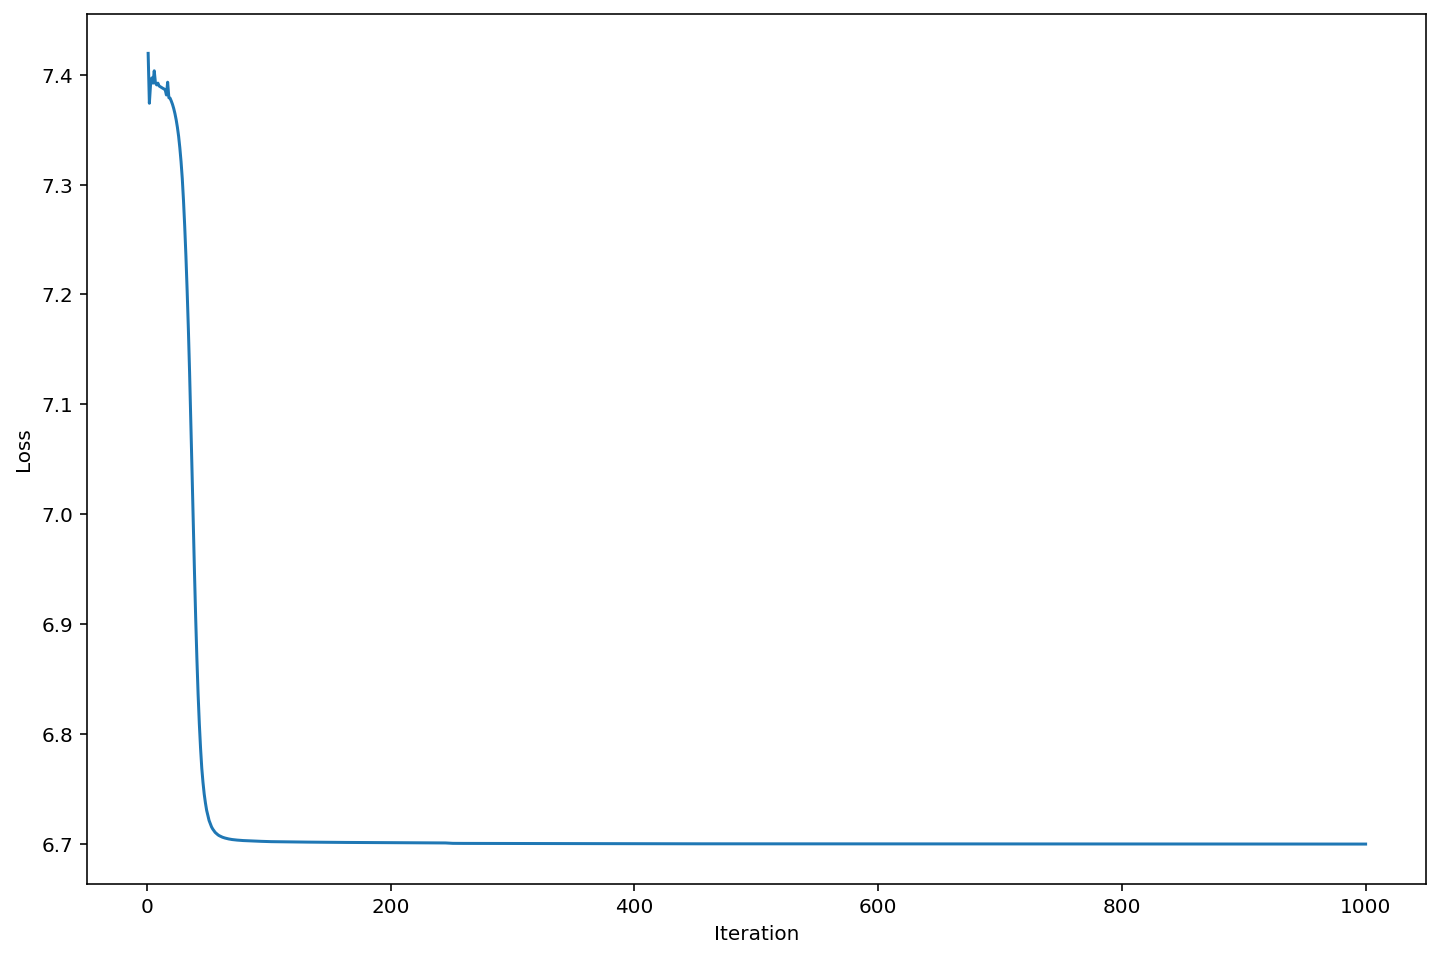

In [24]:
clear_output(wait=True)
plt.figure(figsize=(12, 8))
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.plot(range(1, len(losses)+1), losses)
plt.show()

## Test Model

In [25]:
# model_no_embed = model
# model_embed = model
# model_embed_bi = model
# model = torch.load(DATA_SAVE_PATH+"long_trained_model_4-7-2021.pt")

In [26]:
def vector_to_chord(vect):
    """
    Convert a single class vector to the chord it represents
    """
    ix = torch.argmax(vect)
    c_str = ix_to_chord[ix.item()]

    try:
        if " " in c_str:  # multiple pitches
            c = m21.chord.Chord(c_str)
        else:  # one pitch
            c = m21.note.Note(c_str)

        return c
    except:
        # a roman numeral
        return m21.roman.RomanNumeral(c_str, m21.key.Key("C"))


def model_out_to_scores(output, ix_to_chord, debug=False):
    """
    Convert the model's output into music format

    Args:
        output (Tensor): shape (batches, seq_len, XfeaturesX 1).  ouptut from model.
    
    Returns list of music21.Stream: more comprehensible musical representation of output.
    """
    scores = []

    # for each score in the batch
    for score in output:
        if debug:
            print("predictions:\n", score)
        # music21.Stream will represent the score
        stream = m21.stream.Stream()
        chord_ixs = torch.argmax(score, dim=1)
        # for each chord in the score
        for ix in chord_ixs:
            if debug:
                print("chord ix:", ix.item())
                print("chord str:", "'"+ix_to_chord[ix.item()]+"'")
            # convert from index to chord, add to stream
            chord_str = ix_to_chord[ix.item()]
            
            try:
                if " " in chord_str:  # multiple pitches
                    chord = m21.chord.Chord(chord_str)
                    stream.append(chord)
                else:  # Chord needs multiple, just create a Note
                    note = m21.note.Note(chord_str)
                    stream.append(note)
            except:
                # a roman numeral
                stream.append(m21.roman.RomanNumeral(chord_str, m21.key.Key("C")))
        # add stream to list of scores
        scores.append(stream)

    return scores


def test_on_training_excerpt(model, device, t_y):
    """
    Provide a model with input taken from training data, print some info on its output

    Args:
        model (torch.nn.Module): The model to test
        device: Processor to keep data on
        t_y (int): The number of tokens to generate
    """
    # get appropriate input to give model
    if model.has_embedding:
        # inputs should be indices referring to columns in embedding matrix
        input = tensorX[0][None, :t_y, ...].to(device)
    else:
        # inputs should be one-hot vectors referring to vocab entries
        input = tensorX_oh[0][None, :t_y, ...].to(device)
    
    print("input shape:", input.shape)
    
    # apply model to the input data
    out, _h = model(input, [t_y])

    # process the model's output
    scores_out = model_out_to_scores(out, ix_to_chord, debug=False)
    sample_score = scores_out[0]  # first (and only) piece given to model
    show_example(sample_score)


def test_generation(model, device, t_y):
    """
    Sample from a model's outputs to generate a sequence that it thinks is likely

    Args:
        model (torch.nn.Module): The model to test
        device: Processor to keep data on
        t_y (int): The number of tokens to generate
    """
    # get an appropriate starting input for the model
    start_ix = [chord_to_ix["start"]]
    if model.has_embedding:
        # if the model uses an embedding layer
        input = torch.tensor(start_ix)[None, ...].to(device)
    else:
        # if the model needs one-hot vector inputs
        input = ixs_to_oh(start_ix, len(chord_to_ix))[None, ...].to(device)
    
    # repeatedly give the model its last predictions and hidden/cell state to get next prediction
    hc = None  # start with 0 hidden/cell state
    s = m21.stream.Stream()
    for t in range(t_y):
        out, hc = model(input, [1], hc)
        s.append(vector_to_chord(out))
        print("next prediction:", out)

        input = torch.argmax(out, dim=1)
        # just for no-embedding model that needs one-hot input:
        if not model.has_embedding:
            input = ixs_to_oh(input, len(ix_to_chord)).to(device)

    show_example(s)

In [27]:
# random input of one hot vectors
input = np.eye(len(chord_to_ix))[np.random.choice(len(chord_to_ix), 10)]
input = torch.tensor(np.expand_dims(input, axis=0)).float()

# input = torch.randint(0, len(chord_to_ix), (1, 10))
# print("input:", input)

out, _h = model(input.to(device), [10])

scores_out = model_out_to_scores(out, ix_to_chord, debug=True)

sample_score = scores_out[0].flat
show_example(sample_score)
# print("roman numerals:")
# for c in sample_score.chordify():
#     print(m21.roman.romanNumeralFromChord(c, m21.key.Key("C")))

RuntimeError: ignored

In [ ]:
# Try the model on some of its training data
test_on_training_excerpt(model, device, 15)

In [ ]:
# Sample from the model 
test_generation(model, device, 15)

In [ ]:
# # try to free up RAM
# try:
#     del scores
#     del new_scores
# except Exception as e:
#     print(e)

In [ ]:
# torch.save(model, DATA_SAVE_PATH+"model.pt")
# torch.cuda.empty_cache()

In [ ]:
# model.embed.weight.shape
# torch.argmax(torch.cat((counts[1:6010], counts[6013:])))
# counts[0]
# Counter(all_chords)
# print(chord_to_int)
# model.embed.weight
all_chords = [c for s in chords_by_score for c in s]
Counter(all_chords).most_common(20)